# 1. Setup Database

* Creating a database schemas for Employee and Department Tables

* Generate mock data for 10 departments and 100 employees mapped to those departments.


 # Intution

 *  **To maintain the budgets on department table by department_wise, onboarding employees on employee tables - analysing based on salary spending wrt to budget, hire new ppls.**

# Database Schema

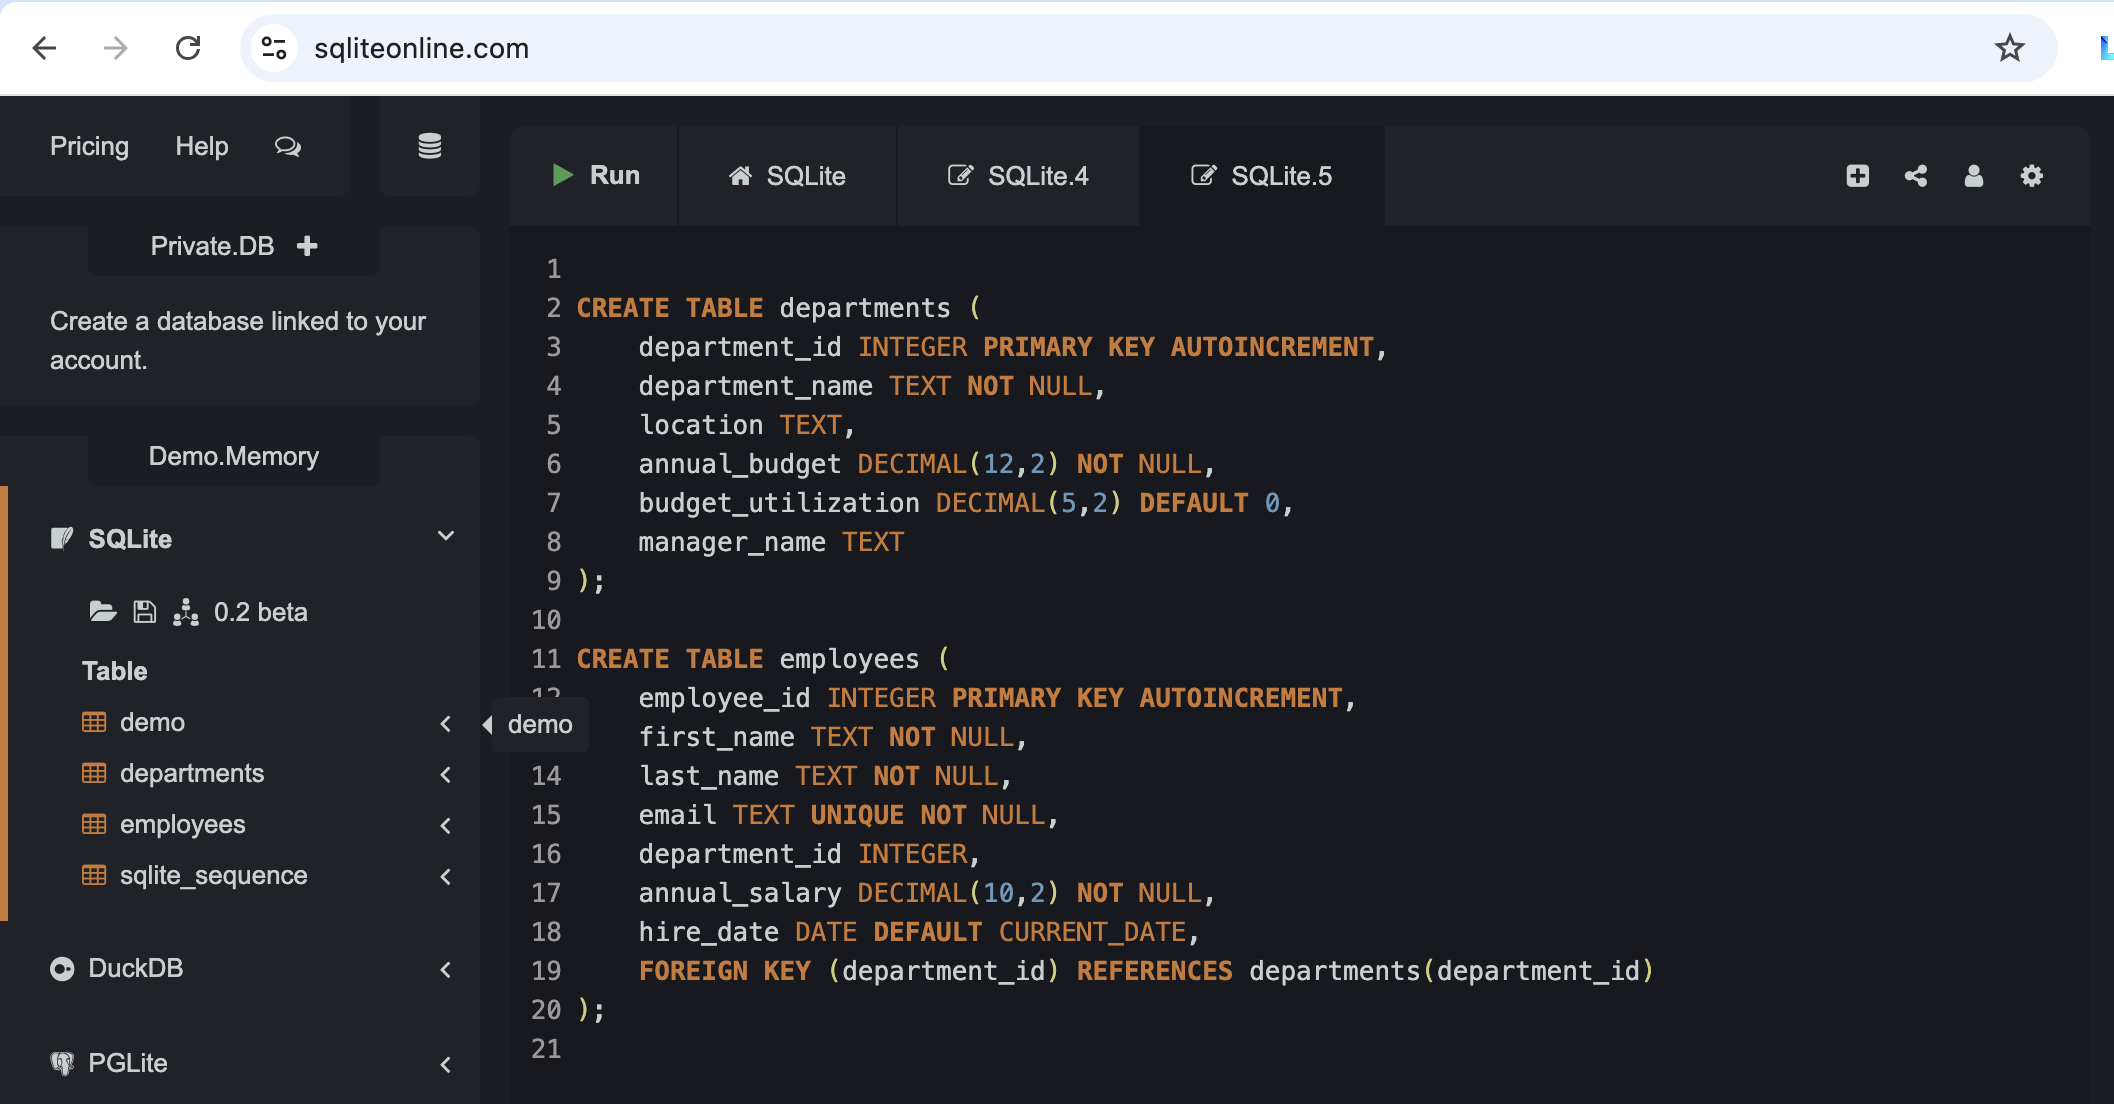

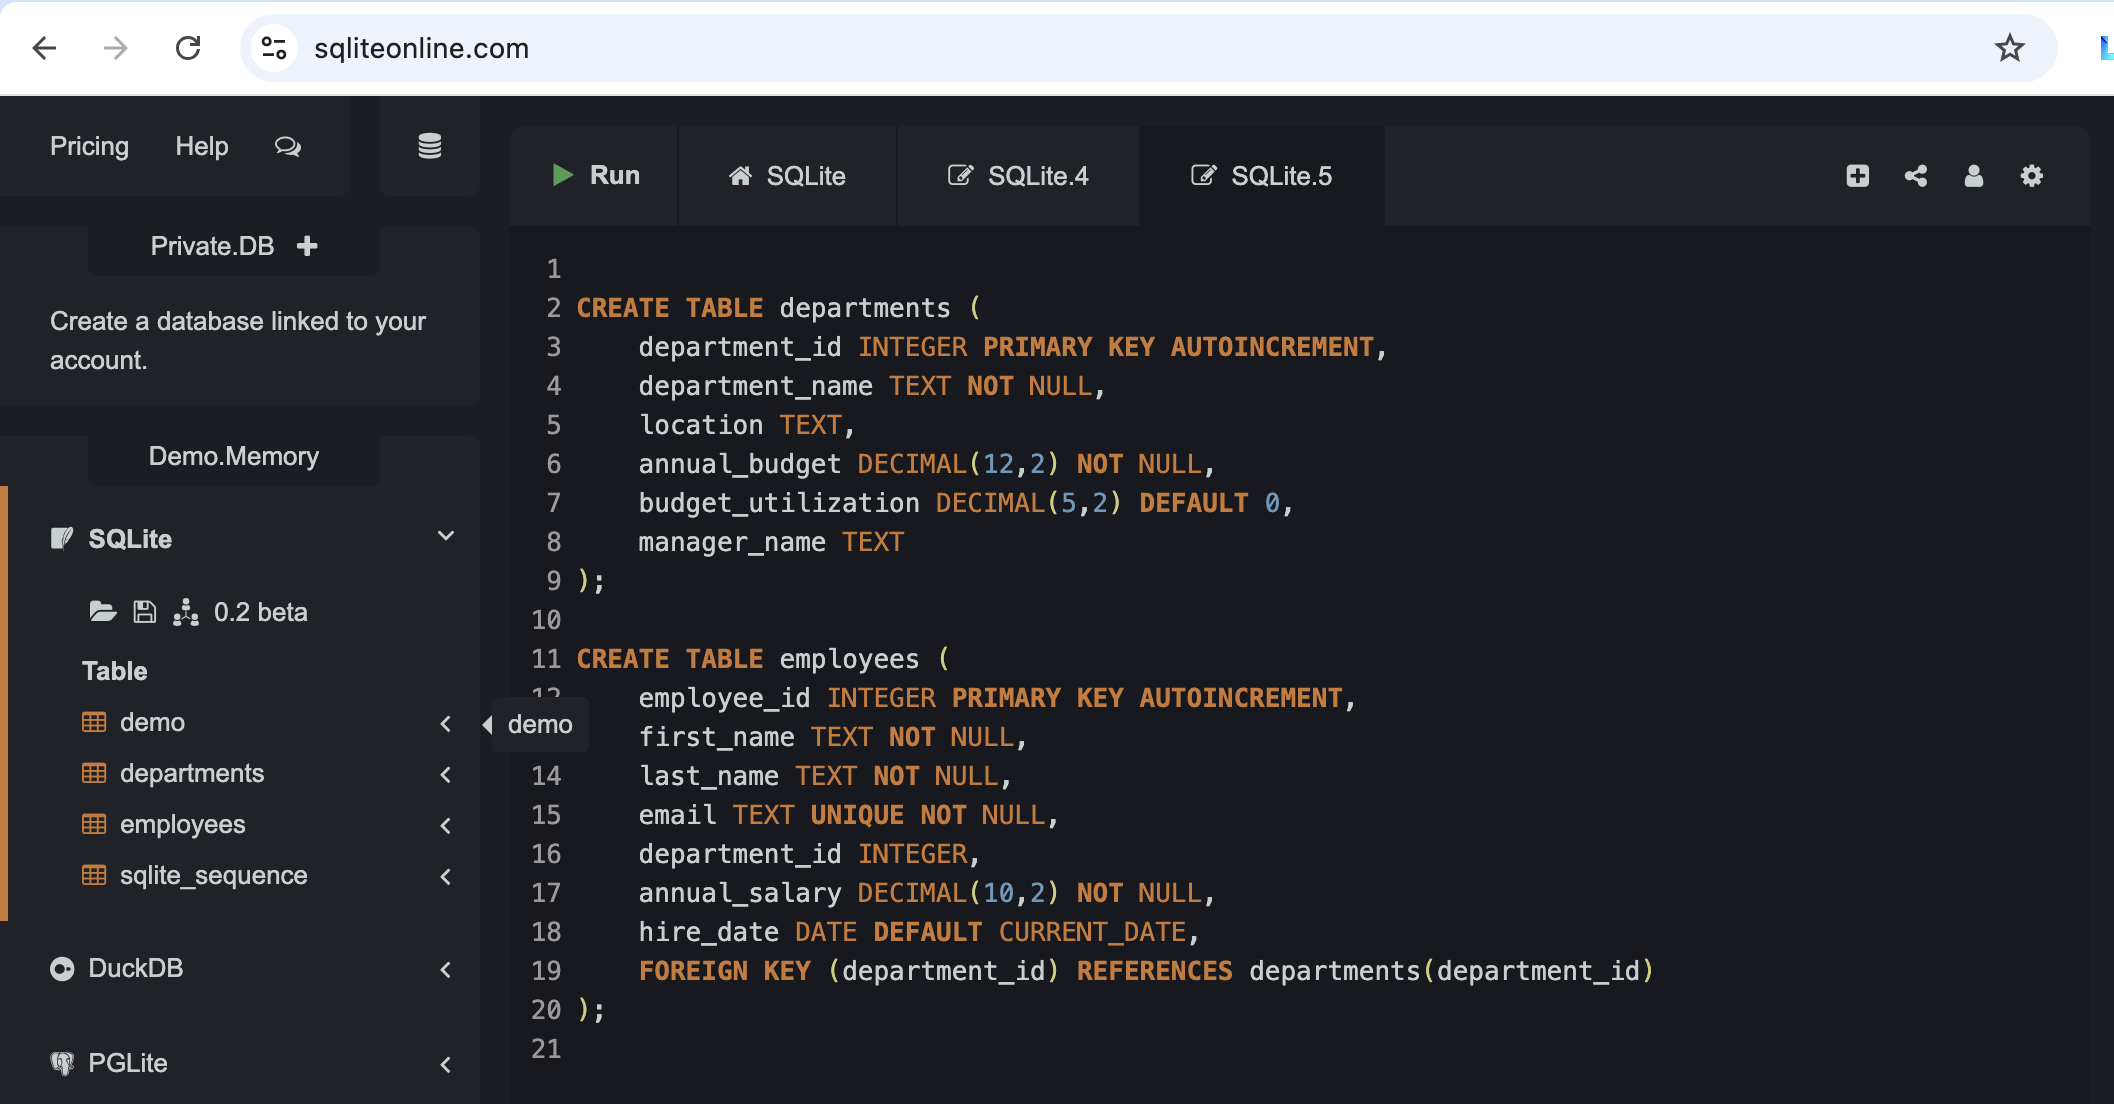

In [1]:
# Department and Employees Tables

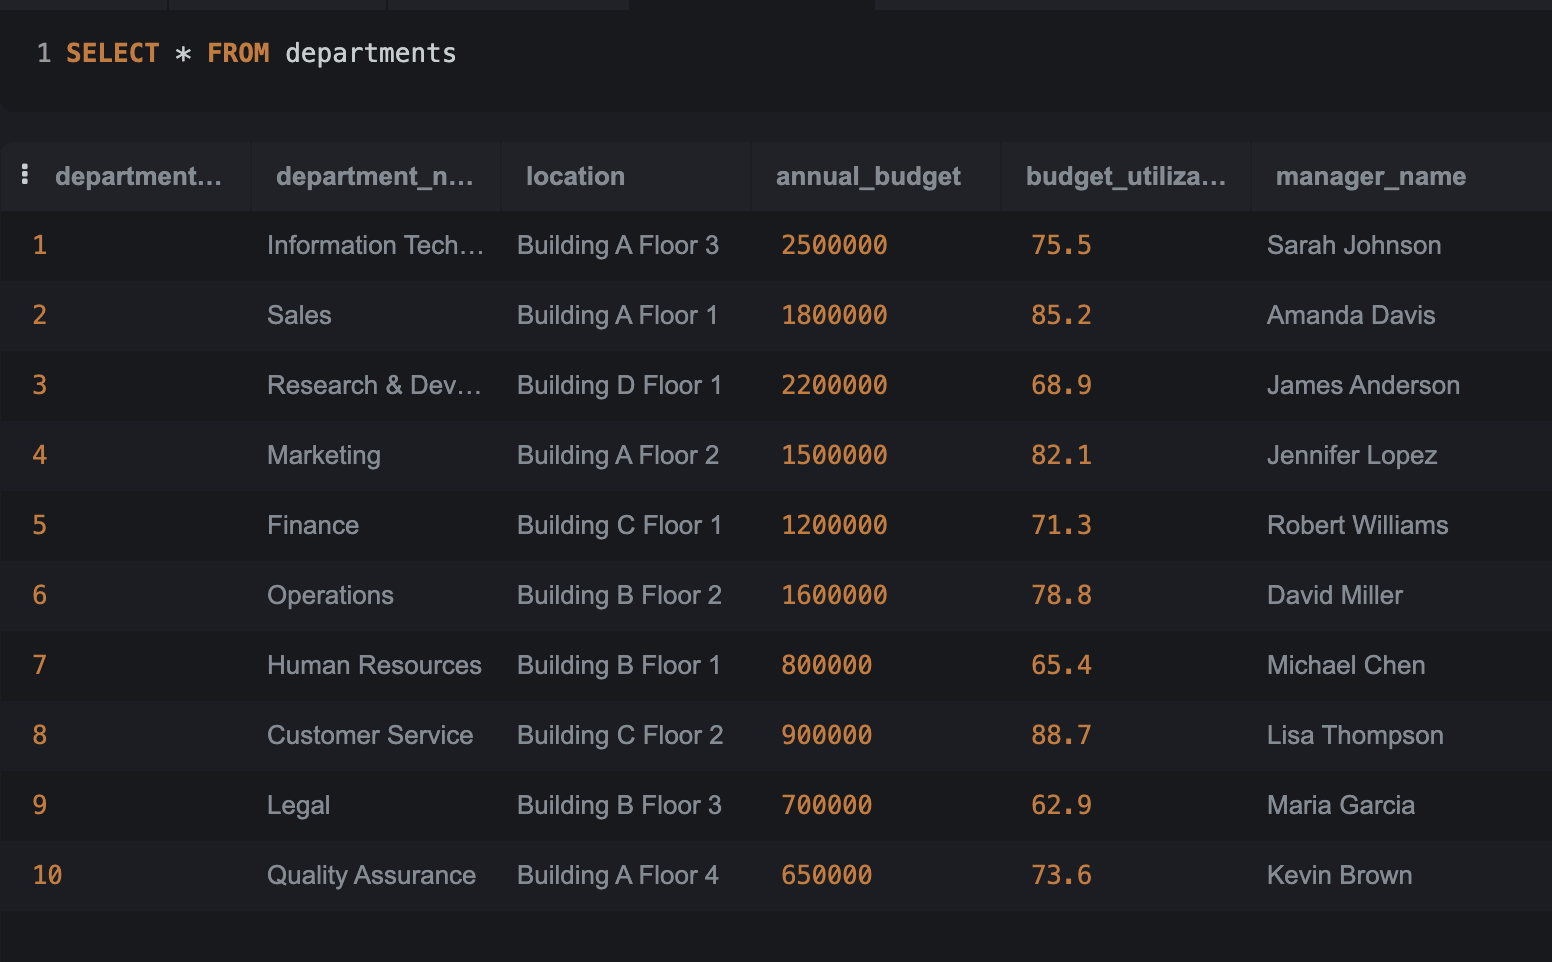

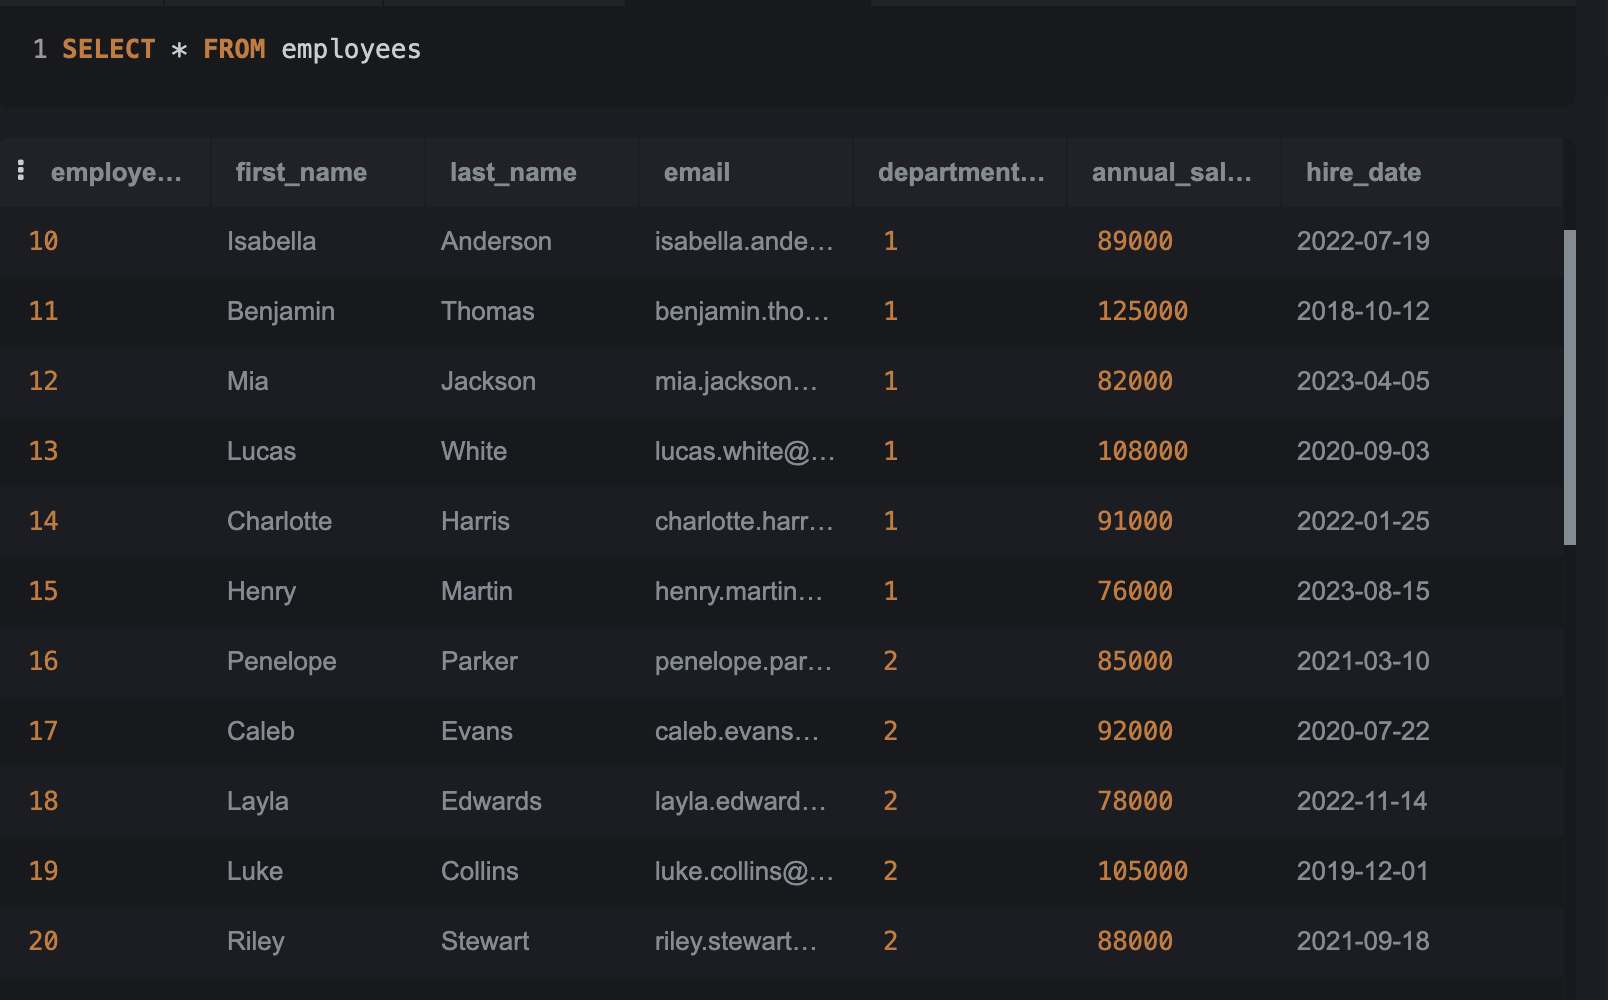

In [2]:
import sqlite3
import pandas as pd
import os

In [4]:
employees_schema = """
  CREATE TABLE employees (
    employee_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    department_id INTEGER,
    annual_salary DECIMAL(10,2) NOT NULL,
    hire_date DATE DEFAULT CURRENT_DATE,
    FOREIGN KEY (department_id) REFERENCES departments(department_id)
);
"""

department_schema = """
  CREATE TABLE departments (
    department_id INTEGER PRIMARY KEY AUTOINCREMENT,
    department_name TEXT NOT NULL,
    location TEXT,
    annual_budget DECIMAL(12,2) NOT NULL,
    budget_utilization DECIMAL(5,2) DEFAULT 0, -- Percentage of budget used
    manager_name TEXT
);
"""

In [5]:
db_name = 'budget.db'
if os.path.exists(db_name):
    os.remove(db_name)
    print(f"Removed existing database '{db_name}'.")

In [7]:
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

In [8]:
cursor.execute(department_schema)
cursor.execute(employees_schema)
conn.commit()
print("Tables created successfully.")

Tables created successfully.


In [9]:
# Load data from CSV files into pandas DataFrames
try:
    departments_df = pd.read_csv('/content/department.csv')
    employees_df = pd.read_csv('/content/employees.csv')

    # Load data into SQLite tables
    departments_df.to_sql('departments', conn, if_exists='append', index=False)
    employees_df.to_sql('employees', conn, if_exists='append', index=False)

    conn.commit()
    print("Data loaded successfully from CSV files.")

except FileNotFoundError:
    print("Error: department.csv and employees.csv are not in the directory.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully from CSV files.


In [11]:
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

print("First 5 rows of the 'departments' table:")
departments_query = "SELECT * FROM departments LIMIT 5;"
departments_result = cursor.execute(departments_query).fetchall()
for row in departments_result:
    print(row)

print("\nFirst 5 rows of the 'employees' table:")
employees_query = "SELECT * FROM employees LIMIT 5;"
employees_result = cursor.execute(employees_query).fetchall()
for row in employees_result:
    print(row)

conn.close()

First 5 rows of the 'departments' table:
(1, 'Information Technology', 'Building A Floor 3', 2500000, 75.5, 'Sarah Johnson')
(2, 'Sales', 'Building A Floor 1', 1800000, 85.2, 'Amanda Davis')
(3, 'Research & Development', 'Building D Floor 1', 2200000, 68.9, 'James Anderson')
(4, 'Marketing', 'Building A Floor 2', 1500000, 82.1, 'Jennifer Lopez')
(5, 'Finance', 'Building C Floor 1', 1200000, 71.3, 'Robert Williams')

First 5 rows of the 'employees' table:
(1, 'John', 'Smith', 'john.smith@company.com', 1, 95000, '2022-03-15')
(2, 'Emma', 'Johnson', 'emma.johnson@company.com', 1, 87000, '2021-08-22')
(3, 'Alex', 'Williams', 'alex.williams@company.com', 1, 112000, '2020-01-10')
(4, 'Sophia', 'Brown', 'sophia.brown@company.com', 1, 78000, '2023-06-01')
(5, 'Michael', 'Davis', 'michael.davis@company.com', 1, 105000, '2021-11-30')


In [10]:
conn.close()
print("Database connection closed.")

Database connection closed.


# 2. Setting up API Key

In [12]:
!pip install google-genai

In [13]:
from google import genai
from google.colab import userdata

In [14]:
genai_client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

# 3. PROMPT-Engineering - ( Unified Framework )

In [26]:
prompt = """Role:
You are an expert-level SQLite Database Engineer specializing in Natural Language to SQL (NL2SQL) translation. Your sole function is to convert user questions written in plain English into accurate, efficient, and syntactically correct SQLite queries based on the fixed database schema provided.

Context:
Your main motive is to keep track of the employee table's salary based on the department's budget allocation.

Database Schema:

employees_schema =
  CREATE TABLE employees (
    employee_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    department_id INTEGER,
    annual_salary DECIMAL(10,2) NOT NULL,
    hire_date DATE DEFAULT CURRENT_DATE,
    FOREIGN KEY (department_id) REFERENCES departments(department_id)
);

department_schema =
  CREATE TABLE departments (
    department_id INTEGER PRIMARY KEY AUTOINCREMENT,
    department_name TEXT NOT NULL,
    location TEXT,
    annual_budget DECIMAL(12,2) NOT NULL,
    budget_utilization DECIMAL(5,2) DEFAULT 0, -- Percentage of budget used
    manager_name TEXT
);

Tasks (Examples):

1.  Find the total annual salary expenditure for each department.
2.  List all employees hired after a specific date.
3.  Find the department with the highest annual budget.

Constraints:

1.  Queries should only use the `employees` and `departments` tables.
2.  Do not perform any data modifications (INSERT, UPDATE, DELETE).
3.  Ensure queries are syntactically correct for SQLite.

Examples:

**Example 1: Successful Query**

User Question: "What is the average salary in the 'Sales' department?"

Expected Response (JSON):

{
  "status": "success",
  "response": "SELECT e.first_name, e.last_name, e.annual_salary FROM employees e JOIN departments d ON e.department_id = d.department_id WHERE d.annual_budget > 2000000;"
}

{
  "status": "clarification_needed",
  "response": "Could you please specify which employee details you would like to see (e.g., name, salary, department)?"
}

{
  "status": "error",
  "response": "I cannot perform data modification operations (INSERT, UPDATE, DELETE)."
}"""

In [37]:
import json
def get_sql_query(genai_client, prompt, user_query):

  contents = f"""
  {prompt}

  Here's the user query in english you need to work on:
  {user_query}
  """
  response = genai_client.models.generate_content(model='gemini-2.5-flash', contents=contents)
  #print(response)

  # Access the usage_metadata attribute
  usage_metadata = response.usage_metadata

  # Print the different token counts
  print(f"Input Token Count: {usage_metadata.prompt_token_count}")
  print(f"Thoughts Token Count: {response.usage_metadata.thoughts_token_count}")
  print(f"Output Token Count: {usage_metadata.candidates_token_count}")
  print(f"Total Token Count: {usage_metadata.total_token_count}")

  output = json.loads(response.text.replace('```json', '').replace('```', ''))

  return output


In [28]:
import sqlite3
import pandas as pd

def execute_query(query, db_name='budget.db'):

    conn = None
    try:
        # Connect to the database
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()

        # Execute the query
        print(f"\nExecuting query on '{db_name}':\n{query}")
        cursor.execute(query)

        # Fetch all results
        results = cursor.fetchall()

        # Get column names from the cursor description
        columns = [description[0] for description in cursor.description]

        # Format results as a dataframe for easier use
        results_as_dict = [dict(zip(columns, row)) for row in results]
        results_df = pd.DataFrame(results_as_dict)

        print("Query executed successfully.")
        return results_df

    except sqlite3.Error as e:
        print(f"Database error executing query: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None
    finally:
        if conn:
            conn.close()

In [29]:
def text2sql(genai_client, prompt, user_query):
  output = get_sql_query(genai_client, prompt, user_query)
  if output['status'] == 'success':
    results = execute_query(output['response'])
    return results
  return output

In [30]:
text2sql(genai_client, prompt, "Show me the department current budget allocation")

sdk_http_response=HttpResponse(
  headers=<dict len=10>
) candidates=[Candidate(
  content=Content(
    parts=[
      Part(
        text="""```json
{
  "status": "success",
  "response": "SELECT department_name, annual_budget FROM departments;"
}
```"""
      ),
    ],
    role='model'
  ),
  finish_reason=<FinishReason.STOP: 'STOP'>,
  index=0
)] create_time=None model_version='gemini-2.5-flash' prompt_feedback=None response_id='NBXZaOGID-qH-8YPuZfJwAI' usage_metadata=GenerateContentResponseUsageMetadata(
  candidates_token_count=33,
  prompt_token_count=576,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=576
    ),
  ],
  thoughts_token_count=59,
  total_token_count=668
) automatic_function_calling_history=[] parsed=None
Input Token Count: 576
Thoughts Token Count: 59
Output Token Count: 33
Total Token Count: 668

Executing query on 'budget.db':
SELECT department_name, annual_budget FROM departments;
Query executed suc

,department_name,annual_budget
0,Information Technology,2500000
1,Sales,1800000
2,Research & Development,2200000
3,Marketing,1500000
4,Finance,1200000
5,Operations,1600000
6,Human Resources,800000
7,Customer Service,900000
8,Legal,700000
9,Quality Assurance,650000


In [36]:
text2sql(genai_client, prompt, "can you say me, which department is utilized by more than 80 percent ")

sdk_http_response=HttpResponse(
  headers=<dict len=10>
) candidates=[Candidate(
  content=Content(
    parts=[
      Part(
        text="""```json
{
  "status": "success",
  "response": "SELECT department_name FROM departments WHERE budget_utilization > 80;"
}
```"""
      ),
    ],
    role='model'
  ),
  finish_reason=<FinishReason.STOP: 'STOP'>,
  index=0
)] create_time=None model_version='gemini-2.5-flash' prompt_feedback=None response_id='6xXZaLHRJ8aNjrEPvraDwQo' usage_metadata=GenerateContentResponseUsageMetadata(
  candidates_token_count=38,
  prompt_token_count=586,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=586
    ),
  ],
  thoughts_token_count=51,
  total_token_count=675
) automatic_function_calling_history=[] parsed=None
Input Token Count: 586
Thoughts Token Count: 51
Output Token Count: 38
Total Token Count: 675

Executing query on 'budget.db':
SELECT department_name FROM departments WHERE budget_utiliz

,department_name
0,Sales
1,Marketing
2,Customer Service


In [39]:
text2sql(genai_client, prompt, "Show departments with highest remaining budget for potential expansion")

Input Token Count: 578
Thoughts Token Count: 1470
Output Token Count: 120
Total Token Count: 2168

Executing query on 'budget.db':
WITH DepartmentRemainingBudget AS (
  SELECT
    department_name,
    annual_budget * (1 - budget_utilization / 100.0) AS remaining_budget
  FROM
    departments
)
SELECT
  department_name,
  remaining_budget
FROM
  DepartmentRemainingBudget
WHERE
  remaining_budget = (SELECT MAX(remaining_budget) FROM DepartmentRemainingBudget);
Query executed successfully.


,department_name,remaining_budget
0,Research & Development,684200.0


In [40]:
text2sql(genai_client, prompt, "can you say me which has very least budget")

Input Token Count: 578
Thoughts Token Count: 106
Output Token Count: 42
Total Token Count: 726

Executing query on 'budget.db':
SELECT department_name, annual_budget FROM departments ORDER BY annual_budget ASC LIMIT 1;
Query executed successfully.


,department_name,annual_budget
0,Quality Assurance,650000


In [41]:
text2sql(genai_client, prompt, "can you list out the employees count based on department wise")

Input Token Count: 580
Thoughts Token Count: 51
Output Token Count: 74
Total Token Count: 705

Executing query on 'budget.db':
SELECT d.department_name, COUNT(e.employee_id) AS employee_count FROM employees e JOIN departments d ON e.department_id = d.department_id GROUP BY d.department_name ORDER BY d.department_name;
Query executed successfully.


,department_name,employee_count
0,Customer Service,8
1,Finance,10
2,Human Resources,8
3,Information Technology,15
4,Legal,4
5,Marketing,12
6,Operations,10
7,Quality Assurance,3
8,Research & Development,12
9,Sales,18


In [42]:
text2sql(genai_client, prompt, "can you list out the employees count based on department wise and also the budget spent, budget remaining")

Input Token Count: 588
Thoughts Token Count: 422
Output Token Count: 120
Total Token Count: 1130

Executing query on 'budget.db':
SELECT d.department_name, COUNT(e.employee_id) AS employee_count, SUM(e.annual_salary) AS budget_spent, (d.annual_budget - SUM(e.annual_salary)) AS budget_remaining FROM departments d LEFT JOIN employees e ON d.department_id = e.department_id GROUP BY d.department_id, d.department_name, d.annual_budget ORDER BY d.department_name;
Query executed successfully.


,department_name,employee_count,budget_spent,budget_remaining
0,Customer Service,8,429000,471000
1,Finance,10,887000,313000
2,Human Resources,8,598000,202000
3,Information Technology,15,1442000,1058000
4,Legal,4,486000,214000
5,Marketing,12,976000,524000
6,Operations,10,810000,790000
7,Quality Assurance,3,215000,435000
8,Research & Development,12,1302000,898000
9,Sales,18,1624000,176000
